In [9]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import math
import json
# gmaps and geojson
import geopy.distance
import gmaps
import gmaps.geojson_geometries

# Google developer API key
from config import gkey
gmaps.configure(api_key=gkey)

# List of Eight World Cities Chosen
cityL=["Amsterdam","Beijing","Las Vegas","Los Angeles","Madrid","New York","Paris","Sydney"]

# file to save geocodes for each city
geo_data_file = os.path.join("Resources","geocodes.csv")

# Hotels CSV File
file_one = 'hotels.csv'

In [10]:
# Get location and bounding box latitude and longitude for each city using Google geocode
base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

geobounds=[]
params={
    "key": gkey
}
for city in cityL:
    params["address"] = city
    response = requests.get(base_url, params=params)
    geo_data = response.json()
    cdict={"city":city}
    cdict["lat"] = geo_data["results"][0]["geometry"]["location"]["lat"]
    cdict["lng"] = geo_data["results"][0]["geometry"]["location"]["lng"]
    cdict["lat1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lat"]
    cdict["lng1"] = geo_data["results"][0]["geometry"]["bounds"]["northeast"]["lng"]
    cdict["lat2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lat"]
    cdict["lng2"] = geo_data["results"][0]["geometry"]["bounds"]["southwest"]["lng"]
    geobounds.append(cdict)

geodf = pd.DataFrame(geobounds)

# save geography coords
geodf.to_csv(geo_data_file, index = False)

geodf

,city,lat,lat1,lat2,lng,lng1,lng2
0,Amsterdam,52.367984,52.431157,52.278139,4.903561,5.068390,4.728856
1,Beijing,39.904200,41.060816,39.442758,116.407396,117.514625,115.423411
2,Las Vegas,36.169941,36.380623,36.129623,-115.139830,-115.062072,-115.414625
3,Los Angeles,34.052234,34.337306,33.703652,-118.243685,-118.155289,-118.668176
4,Madrid,40.416775,40.563845,40.312064,-3.703790,-3.524911,-3.834162
5,New York,40.712775,40.917577,40.477399,-74.005973,-73.700272,-74.259090
6,Paris,48.856614,48.902145,48.815573,2.352222,2.469921,2.224199
7,Sydney,-33.868820,-33.578141,-34.118347,151.209295,151.343021,150.520929


In [11]:
# retrieve geography coords without re-running cell above
geodf = pd.read_csv(geo_data_file, index_col = "city")
geodf

,lat,lat1,lat2,lng,lng1,lng2
city,,,,,,
Amsterdam,52.367984,52.431157,52.278139,4.903561,5.068390,4.728856
Beijing,39.904200,41.060816,39.442758,116.407396,117.514625,115.423411
Las Vegas,36.169941,36.380623,36.129623,-115.139830,-115.062072,-115.414625
Los Angeles,34.052234,34.337306,33.703652,-118.243685,-118.155289,-118.668176
Madrid,40.416775,40.563845,40.312064,-3.703790,-3.524911,-3.834162
New York,40.712775,40.917577,40.477399,-74.005973,-73.700272,-74.259090
Paris,48.856614,48.902145,48.815573,2.352222,2.469921,2.224199
Sydney,-33.868820,-33.578141,-34.118347,151.209295,151.343021,150.520929


In [12]:
# Hotels DataFrame
citydf = pd.read_csv(file_one)
citydf.head()

/Users/admin/anaconda3/envs/PythonData/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,hotelName,stars,price,cityName,countryCode,countryName,address,location,url,latitude,longitude
0,Fafa Island Resort,3.0,172,NukuAlofa,TO,Tonga,Fafa Island PO Box 1444,NukuAlofa Tonga,NaN,-21.0862,-175.160
1,International Dateline Hotel,3.0,99999,NukuAlofa,TO,Tonga,P.O.Box 39 Vuna Road,NukuAlofa Tonga,http://www.datelinehotel.com/,-21.1263,-175.213
2,Kava Palm Guesthouse NukuAlofa,2.0,99999,NukuAlofa,TO,Tonga,Taufaa ahau Road,NukuAlofa Tonga,NaN,-21.1599,-175.229
3,Lagoon Lodge Nuku‘alofa,3.0,99,NukuAlofa,TO,Tonga,Umusi Road Fanga’uta Lagoon Ma’ufanga,NukuAlofa Tonga,NaN,-21.153,-175.231
4,Likualofa Beach Resort,3.0,105,Kanokupolu,TO,Tonga,Private Bag No.2,Kanokupolu Tonga,NaN,-21.0822,-175.345


In [13]:
# Convert latitude into numeric
citydf['latitude'] = pd.to_numeric(citydf['latitude'], errors='coerce')

In [14]:
citydf.dtypes

hotelName       object
stars          float64
price            int64
cityName        object
countryCode     object
countryName     object
address         object
location        object
url             object
latitude       float64
longitude      float64
dtype: object

In [15]:
# retrieve Hotels info saved in folders with city names, merge into one dataframe

# function for returning distance to point center for row with latitude and longitude in df
def get_distance (row, center):
    start = (row['latitude'], row['longitude'])
    return geopy.distance.distance(start, center).km

dfexists = False

for city in cityL:
    #print(path)
    citydf = pd.read_csv(file_one)
    citydf['latitude'] = pd.to_numeric(citydf['latitude'], errors='coerce')
    citydf["key"]=city
    # make sure this only includes locations within city bounding box
    coords = geodf.loc[city]
    citydf = citydf.loc[(citydf["latitude"] <= coords["lat1"]) & (citydf["latitude"] >= coords["lat2"])&(citydf["longitude"] <= coords["lng1"]) & (citydf["longitude"] >= coords["lng2"])]
    # add a new column, distance to center
    center = (coords["lat"],coords["lng"])
    citydf["center_distance"] = citydf.apply (lambda row: get_distance(row, center),axis=1)
    if dfexists:
        allcitydf = pd.concat([allcitydf, citydf], ignore_index=True)
    else:
        allcitydf = citydf
        dfexists = True


allcitydf.head()

,hotelName,stars,price,cityName,countryCode,countryName,address,location,url,latitude,longitude,key,center_distance
0,A & A Shortstay Apartment,1.0,99999,Amsterdam,NL,Netherlands,Prinsengracht 771,Amsterdam Netherlands,NaN,52.3635,4.88718,Amsterdam,1.222338
1,Aalborg Hotel Amsterdam,3.0,39,Amsterdam,NL,Netherlands,Sarphatipark 106,Amsterdam Netherlands,http://www.aalborg.nl/,52.3537,4.89746,Amsterdam,1.642923
2,Acostar Hotel,2.0,76,Amsterdam,NL,Netherlands,Kerkstraat 45-49,Amsterdam Netherlands,http://www.acostar.nl/_en/contact.html,52.3654,4.88553,Amsterdam,1.261432
3,Acro Hotel Amsterdam,2.0,51,Amsterdam,NL,Netherlands,Jan Luijkenstraat 44,Amsterdam Netherlands,http://poethotelamsterdam.com/,52.3599,4.88191,Amsterdam,1.727578
4,Admiraal De Ruijterweg Apartment,3.0,377,Amsterdam,NL,Netherlands,614 1055 ND,Amsterdam Netherlands,NaN,52.3840,4.84780,Amsterdam,4.194804


In [16]:
# get approx city bounding box size for metro size area comparison, approx listing density
sizeL = []

for city in cityL:
    cdict={"city":city}
    coords = geodf.loc[city]
    width = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat2'],coords['lng1'])).km
    height = geopy.distance.distance((coords['lat1'],coords['lng1']),(coords['lat1'],coords['lng2'])).km
    cdict["width"]=width
    cdict["height"]=height
    cdict["area"] = width * height
    #cdict["listing_count"] = allcitydf.loc[allcitydf["key"]==city]['id'].count()
    #cdict["list/sq_km"] = cdict["listing_count"]/cdict["area"]
    sizeL.append(cdict)
    
boundsizedf = pd.DataFrame(sizeL).set_index("city")
boundsizedf

,area,height,width
city,,,
Amsterdam,393.218475,23.093845,17.026982
Beijing,31581.847155,175.778629,179.668299
Las Vegas,881.067578,31.634010,27.851909
Los Angeles,3317.164091,47.194780,70.286673
Madrid,732.221512,26.189575,27.958511
New York,2301.053447,47.074680,48.880916
Paris,173.438539,18.015094,9.627402
Sydney,4573.173991,76.322001,59.919472


In [17]:
# list cols in db
allcitydf.columns

Index(['hotelName', 'stars', 'price', 'cityName', 'countryCode', 'countryName',
       'address', 'location', 'url', 'latitude', 'longitude', 'key',
       'center_distance'],
      dtype='object')

In [18]:
# Convert Price into Numeric
allcitydf['price']= allcitydf['price'].astype(float)
allcitydf.count()

hotelName          6643
stars              6643
price              6643
cityName           6643
countryCode        6643
countryName        6643
address            6643
location           6643
url                5342
latitude           6643
longitude          6643
key                6643
center_distance    6643
dtype: int64

In [19]:
# Multiple Rating by 20
allcitydf['stars'] *= 20
allcitydf.head(2)

,hotelName,stars,price,cityName,countryCode,countryName,address,location,url,latitude,longitude,key,center_distance
0,A & A Shortstay Apartment,20.0,99999.0,Amsterdam,NL,Netherlands,Prinsengracht 771,Amsterdam Netherlands,NaN,52.3635,4.88718,Amsterdam,1.222338
1,Aalborg Hotel Amsterdam,60.0,39.0,Amsterdam,NL,Netherlands,Sarphatipark 106,Amsterdam Netherlands,http://www.aalborg.nl/,52.3537,4.89746,Amsterdam,1.642923


In [20]:
# Delete Prices equal to 99999.0

allcitydf = allcitydf.loc[allcitydf['price']!=99999.0]
allcitydf["price"].describe()

count    5636.000000
mean      110.575053
std        89.241508
min        10.000000
25%        57.000000
50%        90.000000
75%       139.000000
max      1892.000000
Name: price, dtype: float64

In [21]:
# dataframe with useful categories
catsdf = allcitydf[['hotelName','latitude','longitude','price','stars','key','center_distance']]
catsdf.head()

,hotelName,latitude,longitude,price,stars,key,center_distance
1,Aalborg Hotel Amsterdam,52.3537,4.89746,39.0,60.0,Amsterdam,1.642923
2,Acostar Hotel,52.3654,4.88553,76.0,40.0,Amsterdam,1.261432
3,Acro Hotel Amsterdam,52.3599,4.88191,51.0,40.0,Amsterdam,1.727578
4,Admiraal De Ruijterweg Apartment,52.3840,4.84780,377.0,60.0,Amsterdam,4.194804
5,Admiral B&B,52.3705,4.85635,96.0,20.0,Amsterdam,3.227802


In [22]:
# Rename star Column
catsdf = catsdf.rename(columns={"stars":"rating"})
catsdf.head(2)

,hotelName,latitude,longitude,price,rating,key,center_distance
1,Aalborg Hotel Amsterdam,52.3537,4.89746,39.0,60.0,Amsterdam,1.642923
2,Acostar Hotel,52.3654,4.88553,76.0,40.0,Amsterdam,1.261432


In [23]:
# Number of counts after removing the value 99999
catsdf.count()

hotelName          5636
latitude           5636
longitude          5636
price              5636
rating             5636
key                5636
center_distance    5636
dtype: int64

In [24]:
# get average ratings/price for each city 
meandf = catsdf.groupby(["key"])[['price','rating']].mean()
meandf.head(10)

,price,rating
key,,
Amsterdam,135.356713,52.525050
Beijing,59.370318,63.116608
Las Vegas,49.142857,54.142857
Los Angeles,121.460905,54.773663
Madrid,70.604918,57.131148
New York,174.198276,60.100575
Paris,134.102632,56.789474
Sydney,120.682353,70.970588


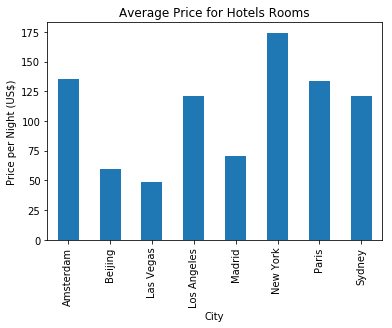

In [25]:
# bar plot mean price comparison for each city
meandf["price"].plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Price per Night (US$)")
plt.title ("Average Price for Hotels Rooms")
plt.savefig("Images/NY_price_barplot.png")
plt.show()

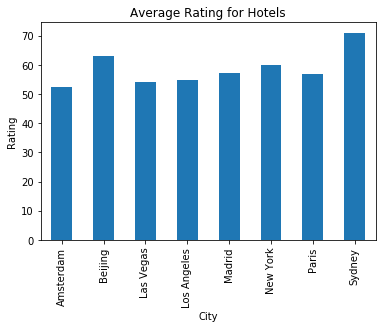

In [26]:
# bar plot mean rating comparison for each city
meandf["rating"].plot(kind='bar')
plt.xlabel("City")
plt.ylabel("Rating")
plt.title ("Average Rating for Hotels")
plt.savefig("Images/NY_rating_barplot.png")
plt.show()

In [27]:
# Plot Heatmap of New York Listings with Intensity by Price

newyorkdf= catsdf.loc[catsdf["key"]=="New York"]
locations = newyorkdf[["latitude", "longitude"]]
pricing = newyorkdf["price"]

coords = geodf.loc["New York"]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pricing,
                                    max_intensity=400, point_radius=3.0)
fig.add_layer(heatmap_layer)
plt.savefig("Images/NY_price_heatmap.png")
fig

Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>

In [28]:
# Heatmap with intensity by rating
rating = newyorkdf["rating"]

coords = geodf.loc["New York"]
cen = (coords["lat"],coords["lng"])
fig = gmaps.figure(map_type='HYBRID', center=cen, zoom_level=11)
heatmap_layer = gmaps.heatmap_layer(locations, weights=rating,
                                    max_intensity=400, point_radius=3.0)
fig.add_layer(heatmap_layer)
plt.savefig("Images/NY_rating_heatmap.png")
fig

Figure(layout=FigureLayout(height='420px'))

<Figure size 432x288 with 0 Axes>